In [96]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
'''

from __future__ import print_function

import os
import sys
import numpy as np
import json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,Dropout
from keras.models import Model, Sequential
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import regularizers
import matplotlib.pyplot as plt

In [97]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 150
MAX_NUM_WORDS = 4000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [98]:


# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [99]:
file_list = os.listdir('data')
file_list
X=[]
Y=[]
for file in file_list:
    with open('data/'+file,'r') as f:
        d = json.load(f)
        X.extend(d['text'].values())
        Y.extend(d['sentiment'].values())

In [100]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3710 unique tokens.


In [101]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [102]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(Y)

Y = tokenizer.texts_to_matrix(Y)

Y = np.asarray([a[1:] for a in Y])

In [103]:
Y#[positive,neutral,negative]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [104]:
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (622, 150)
Shape of label tensor: (622, 3)


In [105]:
(x_train,x_test,y_train,y_test)=train_test_split(X,Y,random_state=42)

In [106]:
x_train.shape

(466, 150)

In [107]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [108]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [109]:
rglrzr = regularizers.l2(0.001)

In [110]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 3, activation='relu',kernel_regularizer=rglrzr))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 100)          371100    
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 148, 128)          38528     
_________________________________________________________________
dropout_8 (Dropout)          (None, 148, 128)          0         
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 27        
Total para

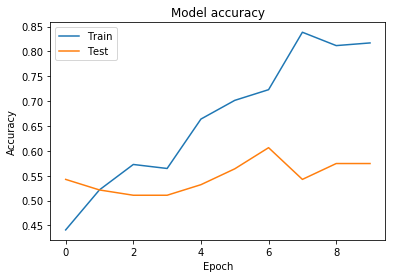

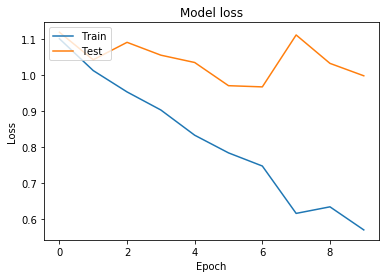

In [111]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [112]:
y_pred = model.predict(x_test)
def maxpos(li):
    if li[0]>li[1] and li[0]>li[2] :
        return 0
    if li[1]>li[2] and li[1]>li[0] :
        return 1
    return 2
y_pre=[maxpos(y) for y in y_pred]
y_tes=[maxpos(y) for y in y_test]

In [113]:
confusion_matrix(y_true=y_tes,y_pred=y_pre)

array([[56, 30,  0],
       [17, 41,  1],
       [ 4,  7,  0]], dtype=int64)

In [28]:
'''
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history=model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test))
'''

"\nsequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')\nembedded_sequences = embedding_layer(sequence_input)\nx = Conv1D(128, 5, activation='relu')(embedded_sequences)\nx = MaxPooling1D(5)(x)\nx = Conv1D(128, 5, activation='relu')(x)\nx = MaxPooling1D(5)(x)\nx = Conv1D(128, 5, activation='relu')(x)\nx = GlobalMaxPooling1D()(x)\nx = Dense(128, activation='relu')(x)\npreds = Dense(3, activation='softmax')(x)\n\nmodel = Model(sequence_input, preds)\nmodel.compile(loss='categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['acc'])\n\nhistory=model.fit(x_train, y_train,\n          batch_size=128,\n          epochs=10,\n          validation_data=(x_test, y_test))\n"